In [1]:
from torchvision import datasets, transforms
import numpy as np
import random
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import cv2
from keras.models import model_from_json
#from ipywidgets import IntProgress

In [2]:
image_size=14 #have to be even

In [3]:
#defining the transformation method
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(image_size),
    transforms.Normalize((0.5), (0.5,)),
])

transform_train_minor = transforms.Compose([
    transforms.RandomPerspective(),
    transforms.RandomCrop(image_size),
    transforms.RandomHorizontalFlip(),
])

In [83]:
#downloading the dataset
# dataset_train = datasets.EMNIST('../data/cifar',split='digits', train=True, download = True, transform = transform)
# dataset_test = datasets.EMNIST('../data/cifar-t',split='digits',train=False, download = True, transform = transform)
dataset_train = datasets.CIFAR10('../data/cifar', train=True, download = True, transform = transform)
dataset_test = datasets.CIFAR10('../data/cifar-t',train=False, download = True, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [69]:
#this function is sampling the cifar image index in non iid way, each client will have majority of 2 class and 8 minor class
def distribute_noniid2(dataset, num_users, p):

    idxs = np.arange(len(dataset),dtype=int)
    labels = np.array(dataset.targets)
    label_list = np.unique(dataset.targets)
    
    # sort labels
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:,idxs_labels[1,:].argsort()]
    #print(idxs_labels)
    idxs = idxs_labels[0,:]
    idxs = idxs.astype(int)
    n_data=int(len(dataset)/(6*num_users))
    dict_users = {i: np.array([], dtype='int64') for i in range(num_users)}

    #Sample majority class for each user
    user_majority_labels = []
    for i in range(num_users):
        majority_labels = np.random.choice(label_list, 2, replace = False) #2 represent the numbers of majority classes each user will have
        user_majority_labels.append(majority_labels)
        #label_list = list(set(label_list) - set(majority_labels))
        #print(label_list)
        print(i,majority_labels)
        majority_label_idxs = (majority_labels[0] == labels[idxs])| (majority_labels[1] == labels[idxs])# |  (majority_labels[2] == labels[idxs]) | (majority_labels[3] == labels[idxs]) |  (majority_labels[4] == labels[idxs]) | (majority_labels[5] == labels[idxs]) |  (majority_labels[6] == labels[idxs]) | (majority_labels[7] == labels[idxs]) |  (majority_labels[8] == labels[idxs]) | (majority_labels[9] == labels[idxs]) |  (majority_labels[10] == labels[idxs]) | (majority_labels[11] == labels[idxs]) |  (majority_labels[12] == labels[idxs]) | (majority_labels[13] == labels[idxs]) | (majority_labels[14] == labels[idxs]) | (majority_labels[15] == labels[idxs]) |  (majority_labels[16] == labels[idxs]) | (majority_labels[17] == labels[idxs]) |  (majority_labels[18] == labels[idxs]) | (majority_labels[19] == labels[idxs]) 
        
        sub_data_idxs = np.random.choice(idxs[majority_label_idxs], int(p*n_data), replace = False)
        
        dict_users[i] = np.concatenate((dict_users[i],sub_data_idxs))
        idxs = np.array(list(set(idxs) - set(sub_data_idxs)))
        
        #assigning minor classes to each client
    if(p < 1.0):
        for i in range(num_users):
            majority_labels = user_majority_labels[i]
            
            non_majority_label_idxs = (majority_labels[0] != labels[idxs]) | (majority_labels[1] != labels[idxs])# |  (majority_labels[2] != labels[idxs]) | (majority_labels[3] != labels[idxs]) |  (majority_labels[4] != labels[idxs]) | (majority_labels[5] != labels[idxs]) |  (majority_labels[6] != labels[idxs]) | (majority_labels[7] != labels[idxs]) |  (majority_labels[8] != labels[idxs]) | (majority_labels[9] != labels[idxs]) |  (majority_labels[10] != labels[idxs]) | (majority_labels[11] != labels[idxs]) |  (majority_labels[12] != labels[idxs]) | (majority_labels[13] != labels[idxs]) | (majority_labels[14] != labels[idxs]) | (majority_labels[15] != labels[idxs]) |  (majority_labels[16] != labels[idxs]) | (majority_labels[17] != labels[idxs]) |  (majority_labels[18] != labels[idxs]) | (majority_labels[19] != labels[idxs]) 
            
            sub_data_idxs = np.random.choice(idxs[non_majority_label_idxs], int((1-p)*n_data), replace = False)
            
            dict_users[i] = np.concatenate((dict_users[i], sub_data_idxs))
            idxs = np.array(list(set(idxs) - set(sub_data_idxs)))
    idx=int((p)*n_data)
    return dict_users,idx

In [70]:
num_user=50
p=0.7 #p is what percentage in each class, majority classs will cover the dataset
dict_users,idx = distribute_noniid2(dataset_train,num_user,p)

0 [5 0]
1 [5 2]
2 [8 3]
3 [4 5]
4 [9 7]
5 [2 9]
6 [6 2]
7 [0 6]
8 [7 1]
9 [8 3]
10 [8 1]
11 [6 5]
12 [5 2]
13 [5 2]
14 [0 3]
15 [8 0]
16 [4 2]
17 [5 2]
18 [2 6]
19 [5 6]
20 [1 2]
21 [6 2]
22 [7 4]
23 [3 1]
24 [6 1]
25 [9 7]
26 [1 5]
27 [5 8]
28 [5 3]
29 [9 0]
30 [9 6]
31 [6 2]
32 [9 6]
33 [2 4]
34 [2 3]
35 [6 2]
36 [8 3]
37 [4 5]
38 [7 1]
39 [9 2]
40 [9 7]
41 [0 2]
42 [6 8]
43 [6 3]
44 [6 3]
45 [2 0]
46 [5 9]
47 [0 3]
48 [1 6]
49 [7 4]


In [84]:
#using image augmentation twice and add 4 transformed image
def augment_image(dataset,idx,num_user):
    dataset=list(dataset)
    count=len(dataset)-1
    final_idx=len(dict_users[0])
    for j in range(num_user):
        for i in dict_users[j][idx:final_idx]:
            label=dataset[i][1]   #blurring the datatset
            
            img1=cv2.blur(dataset[i][0].numpy(),(2,2))
            img1=np.transpose(img1)
            dataset.append([img1,label])   
            count += 1
            dict_users[j] = np.append(dict_users[j], count)
            
            for k in range(4):
                img2=transform_train_minor(dataset[i][0])  #using the trasformation technique
                img2=np.transpose(img2.numpy())
                dataset.append([img2,label])   
                count += 1
                dict_users[j] = np.append(dict_users[j], count)
            
    return dict_users,dataset

In [85]:
dict_users,dataset_train=augment_image(dataset_train,idx,num_user)

/users/ugrad/aggarwau/.local/lib/python3.8/site-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


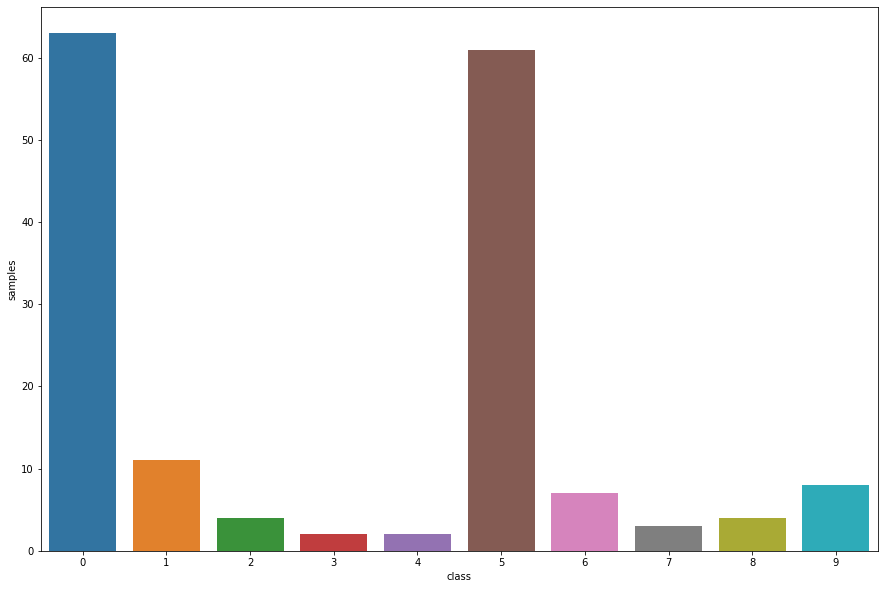

165


In [71]:
# code to check number of images/classes

samples=[]
classes=[]
temp=list()
for i in dict_users[0]: 
    temp.append(dataset_train[i][1])
for i in range(10):
    classes.append(i) 
    samples.append(temp.count(i))

mydict={'class':classes,
           'samples':samples}
plt.figure(figsize=(15,10))
df=pd.DataFrame(mydict,columns=['class','samples'])
sns.barplot(y=df['samples'],x=df['class'],data=df)
plt.show()
print(len(dict_users[0]))

total sample 410


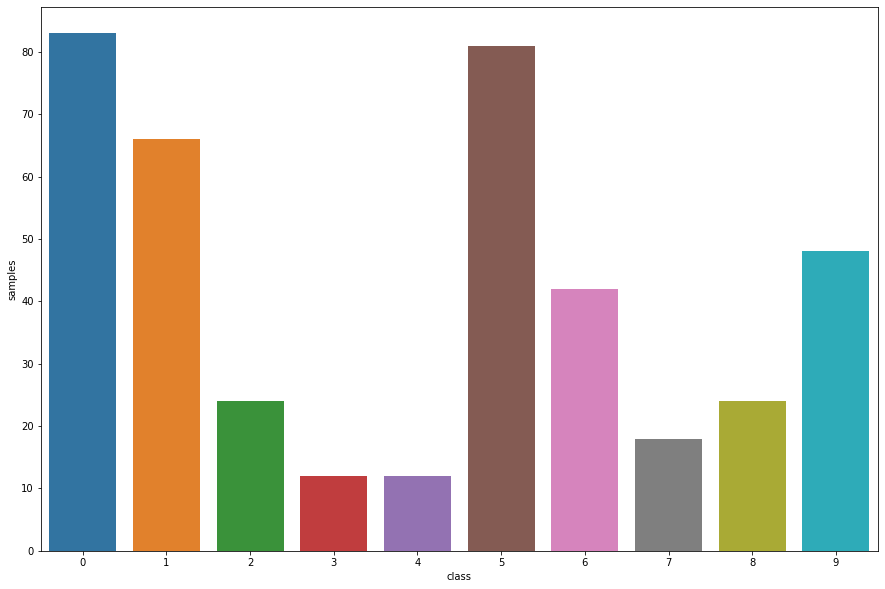

In [86]:
# code to check number of images/classes
samples=[]
classes=[]
temp=list()
for i in dict_users[0]: 
     temp.append(dataset_train[i][1])
for i in range(10):
    classes.append(i) 
    samples.append(temp.count(i))
    
mydict={'class':classes,
       'samples':samples}
plt.figure(figsize=(15,10))
df=pd.DataFrame(mydict,columns=['class','samples'])
sns.barplot(y=df['samples'],x=df['class'],data=df)
print('total sample',len(dict_users[0]))

In [87]:
#checking image shape for each class, if not desired one then converting it 
dataset_train1=[]
for i in range(len(dataset_train)):
    temp=dataset_train[i][0]
    if(temp.shape!=(image_size,image_size,3)):
        temp=np.transpose(temp.numpy())
    dataset_train1.append(temp)

In [88]:
#creating a batch data per client and binarzing the target 
lb=LabelBinarizer()
def batch_data(data_shard):
    bs=len(data_shard)
    label=[]
    img=[]
    for i in data_shard:
        label.append(dataset_train[i][1])
        img.append(dataset_train1[i])    
    label=lb.fit_transform(label)
    dataset = tf.data.Dataset.from_tensor_slices((list(img),list(label)))
    return dataset.shuffle(len(label)).batch(bs)


In [89]:
#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in dict_users.items():
    clients_batched[client_name] = batch_data(data)

In [76]:
num_sample1=len(dataset_test)//2

num_sample=len(dataset_test)
#process and batch the 2test set(one for local model and one for global)
label=[]
data=[]
dataset_test1=[]
for i in range(num_sample1):
    label.append(dataset_test[i][1])
    temp=dataset_test[i][0].numpy()
    image=np.transpose(temp)
    data.append(image) 
label=lb.fit_transform(label)
    
test_batched_1 = tf.data.Dataset.from_tensor_slices((list(data), list(label))).batch(num_sample)

label=[]
data=[]
dataset_test1=[]
for i in range(num_sample1,num_sample):
    label.append(dataset_test[i][1])
    temp=dataset_test[i][0].numpy()
    image=np.transpose(temp)
    data.append(image) 
label=lb.fit_transform(label)
    
test_batched_2 = tf.data.Dataset.from_tensor_slices((list(data), list(label))).batch(num_sample)

In [90]:
#building a simple NN
class SimpleMLP:
    @staticmethod
    def build(classes):
        model = Sequential()
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(image_size,image_size,3)))
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
       # model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.3))
        model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())       
        model.add(Dense(500, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dropout(0.3))
        model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dropout(0.3))
        model.add(Dense(classes, activation='softmax'))
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam', 
                      metrics=['accuracy'])
        #print(model.summary())
        return model

In [91]:
del dataset_test
del dataset_train
del dataset_train1
del dataset_test1
del data

NameError: name 'dataset_test1' is not defined

In [92]:
def scale_model_weights(Z,local_weight,global_weight):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(global_weight)
    alpha=0
    for i in range(steps):
        w_client=np.array(local_weight[i])   #taking local weights
        w_avg= np.array(global_weight[i])    #taking current global weights
        l1=np.linalg.norm(w_avg-w_client)    #calculating the l1 norm
        Z[i] = Z[i] + l1                     #updating the normalizing factor
        alpha=l1/Z[i]                        #calculating the final alpha value
        weight_final.append(alpha * local_weight[i])  #appending the updated weights to the scaled weight list
    return weight_final,Z

def sum_scaled_weights(scaled_list):
    #get the IDA average grad accross all client gradients
    avg_grad = list()
    for grad_list_tuple in zip(*scaled_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
    return avg_grad

def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [93]:
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# global_model = model_from_json(loaded_model_json)
# # load weights into new model
# global_model.load_weights("model.h5")
# print("Loaded model from disk") 

In [94]:
#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(10)

comm_round=40
Z=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#commence global training loop
for comm_round in range(comm_round):     
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()

    #initial list to collect local model weights after scalling
    local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(10)
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
      #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=2, verbose=0,validation_data=test_batched_1)
        
        #scale the model weights and add to list
        scaled_weights,Z = scale_model_weights(Z,local_model.get_weights(),global_model.get_weights())
        local_weight_list.append(scaled_weights)
       
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights= sum_scaled_weights(local_weight_list)
    #update global model 
    global_model.set_weights(average_weights)
    
    model_json = global_model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
        
# serialize weights to HDF5
    global_model.save_weights("model.h5")
    print("Saved model to disk")
    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched_2:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)

Saved model to disk
comm_round: 0 | global_acc: 11.800% | global_loss: 2.3023202419281006
Saved model to disk
comm_round: 1 | global_acc: 14.280% | global_loss: 2.2976598739624023
Saved model to disk
comm_round: 2 | global_acc: 21.620% | global_loss: 2.26842999458313
Saved model to disk
comm_round: 3 | global_acc: 24.160% | global_loss: 2.267639398574829
Saved model to disk
comm_round: 4 | global_acc: 29.680% | global_loss: 2.2307379245758057
Saved model to disk
comm_round: 5 | global_acc: 31.940% | global_loss: 2.233262777328491
Saved model to disk
comm_round: 6 | global_acc: 33.500% | global_loss: 2.195194959640503
Saved model to disk
comm_round: 7 | global_acc: 34.700% | global_loss: 2.1960806846618652
Saved model to disk
comm_round: 8 | global_acc: 36.240% | global_loss: 2.164689064025879
Saved model to disk
comm_round: 9 | global_acc: 37.060% | global_loss: 2.1562323570251465
Saved model to disk
comm_round: 10 | global_acc: 37.880% | global_loss: 2.1424505710601807
Saved model to 